## Preface



If need be&#x2026;



In [19]:
!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:


| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|j,u|t,m|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [20]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

InputFiles = {
    'Expenditures': (Senegal_Data, 'Food Expenditures (2019)'),
    'Prices': (Senegal_Data, 'Food Prices (2019)'),
    'HH Characteristics': (Senegal_Data, 'Household Characteristics'),
    'FCT': (Senegal_Data, 'FCT'),
    'RDI': (Senegal_Data, 'RDI')
}

Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [21]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Clean sheet function
def get_clean_sheet(key, sheet=None):
    df = read_sheets(key, sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    df = df.loc[~df.index.duplicated(), :]
    return df

# Load long-format expenditures and pivot to wide format
x_long = get_clean_sheet(InputFiles['Expenditures'][0], sheet='Food Expenditures (2019)')
x_long['Expenditure'] = pd.to_numeric(x_long['Expenditure'], errors='coerce')

x = x_long.pivot_table(index=['i', 't', 'm'], columns='j', values='Expenditure')
x.columns.name = 'j'
x = x.replace(0, np.nan)

# Load household characteristics
z = get_clean_sheet(InputFiles['HH Characteristics'][0], sheet=InputFiles['HH Characteristics'][1])
if 'm' not in z.columns:
    z['m'] = 1
z = z.set_index(['i', 't', 'm'])
z.columns.name = 'k'
z = z.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Load prices
p = get_clean_sheet(InputFiles['Prices'][0], sheet=InputFiles['Prices'][1])
if 'm' not in p.columns:
    p['m'] = 1
p = p.set_index(['t', 'm'])
p.columns.name = 'j'
p = p.apply(lambda x: pd.to_numeric(x, errors='coerce'))
p = p.replace(0, np.nan)

# Load FCT
fct = get_clean_sheet(InputFiles['FCT'][0], sheet=InputFiles['FCT'][1])
fct = fct.set_index('j')
fct.columns.name = 'n'
fct = fct.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Load RDI
rdi = get_clean_sheet(InputFiles['RDI'][0], sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result.



Number of goods retained in x: 58
z_clean shape: (3477, 20)
Number of unique goods in y: 58
Running CFEDemands regression...
Top demand elasticities:
j
Huile de soja / végétale (e.g., Ninaal, Jaara, etc.)                   3.478855
Riz importé brisé                                                      3.418335
Riz local brisé                                                        3.022347
Lait en poudre                                                         2.868430
Mayonnaise                                                             2.659285
Beurre                                                                 2.639739
Oignon frais                                                           2.578874
Café                                                                   2.528097
Chocolat à croquer, pâte à tartiner                                    2.485064
Vinaigre /moutarde                                                     2.429341
Ail                                             

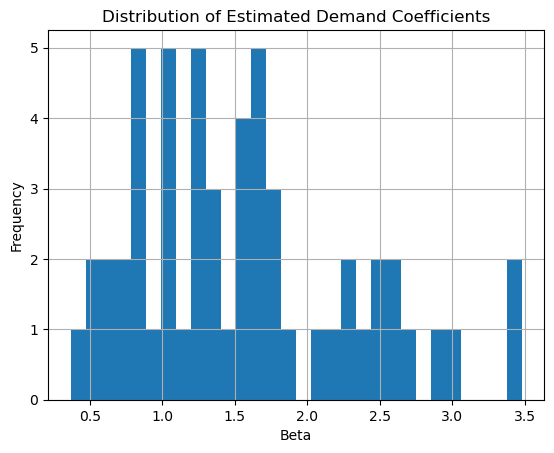

In [22]:
import cfe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Filter x to keep multiple goods ---
# Keep goods with at least 10% non-missing values
x_filtered = x.loc[:, x.notna().mean() > 0.1]
print("Number of goods retained in x:", x_filtered.shape[1])

# Exit early if still not enough
if x_filtered.shape[1] < 2:
    raise ValueError("Still not enough goods with sufficient data. Cannot estimate demand system.")

# --- Prepare y and z ---
y = np.log(x_filtered.stack())
if not y.index.is_unique:
    print("Warning: Duplicate entries in y. Dropping duplicates.")
    y = y[~y.index.duplicated(keep='first')]

# Align z index
itm_index = y.index.droplevel('j').drop_duplicates()
z_clean = z.loc[z.index.intersection(itm_index)]

# Add dummy categorical
z_clean["region_dummy"] = "RegionA"
z_clean["region_dummy"] = z_clean["region_dummy"].astype("category")

# Convert numeric columns
for col in z_clean.columns:
    if z_clean[col].dtype != "category":
        z_clean[col] = z_clean[col].astype(float)

# Drop duplicated indices if any
if not z_clean.index.is_unique:
    z_clean = z_clean[~z_clean.index.duplicated(keep='first')]

print("z_clean shape:", z_clean.shape)
print("Number of unique goods in y:", y.index.get_level_values('j').nunique())

# --- Run regression ---
print("Running CFEDemands regression...")
result = cfe.Regression(y=y, d=z_clean)

# --- Inspect results ---
betas = result.get_beta().sort_values(ascending=False)
print("Top demand elasticities:")
print(betas.sort_values(ascending=False))

betas.hist(bins=30)
plt.title("Distribution of Estimated Demand Coefficients")
plt.xlabel("Beta")
plt.ylabel("Frequency")
plt.show()

Make this persistent&#x2026;



In [23]:
# Save regression result to disk
result.to_pickle('./senegal_regression_result.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [24]:
!pip install fuzzywuzzy
!pip install unidecode

In [44]:
import cfe
import pandas as pd
import numpy as np
from fuzzywuzzy import process

# === Load saved regression result ===
result = cfe.read_pickle('./senegal_regression_result.pickle')

# === Get predicted expenditures ===
xhat = result.predicted_expenditures()

# === Reshape to wide format ===
xhat_wide = xhat.unstack('j')
xhat_wide.columns.name = 'j'
print("xhat_wide shape:", xhat_wide.shape)

# === Load and clean price data ===
p = get_clean_sheet(InputFiles['Prices'][0], sheet=InputFiles['Prices'][1])

# Add market column if missing
if 'm' not in p.columns:
    p['m'] = 1

# Fix duplicated columns
if p.columns.duplicated().any():
    cols = list(p.columns)
    seen = {}
    for i, col in enumerate(cols):
        if col in seen:
            seen[col] += 1
            cols[i] = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
    p.columns = cols

# Make sure required columns exist
assert 'j' in p.columns and 'Price' in p.columns, "Missing expected columns: 'j' and 'Price'"

# Drop rows with missing goods or prices
p = p.dropna(subset=['j', 'Price'])

# Pivot prices to wide format: (t, m) x j
p_wide = p.pivot_table(index=['t', 'm'], columns='j', values='Price')
p_wide.columns.name = 'j'
p_wide = p_wide.apply(pd.to_numeric, errors='coerce').replace(0, np.nan)
print("p_wide shape:", p_wide.shape)

# === Load FCT and clean the French names (column 'k') ===
fct = get_clean_sheet(InputFiles['FCT'][0], sheet=InputFiles['FCT'][1])

# Clean 'k' column to create 'k_clean'
fct_cleaned = fct.copy()
fct_cleaned['k_clean'] = fct_cleaned['k'].str.strip().str.lower()  # Ensure it's properly cleaned
xhat_cleaned_columns = xhat_wide.columns.str.strip().str.lower()

print("\nFirst few cleaned goods in xhat_wide (predicted quantities):")
print(xhat_cleaned_columns[:10])
print("\nFirst few cleaned goods in FCT (French names):")
print(fct_cleaned['k_clean'].head(10))

# === Fuzzy match goods ===
matched_fct_names = []
matched_xhat_names = []
for good in xhat_cleaned_columns:
    result = process.extractOne(good, fct_cleaned['k_clean'])  # No 'limit' argument needed
    if result:  # Ensure there's a result
        # result is a tuple like (match, score), but we need to handle multiple results if returned
        if isinstance(result, tuple) and len(result) == 2:
            match, score = result  # Correctly unpack the result into match and score
        else:
            match = result[0]  # If there's more than one value, just take the first one
            score = result[1]  # Extract the score if needed
        print(f"Trying to match '{good}' -> Match: '{match}' with score {score}")
        if score > 85:  # Lowered threshold to be more inclusive
            matched_fct_names.append(match)
            matched_xhat_names.append(good)

print("\nMatching goods from qhat and FCT:", matched_fct_names)

# === Create a mapping dictionary from xhat names to FCT original names ===
mapping = {}
for fct_good in matched_fct_names:
    original_name = fct_cleaned.loc[fct_cleaned['k_clean'] == fct_good, 'k'].values
    if len(original_name) > 0:
        mapping[fct_good] = original_name[0]

# === Invert mapping to match xhat columns
matched_xhat_names_filtered = [name for name in matched_xhat_names if name in mapping]
matching_goods_in_xhat = [xhat_wide.columns[xhat_cleaned_columns == name][0] for name in matched_xhat_names_filtered]
print(f"\nMatching goods in xhat_wide columns: {matching_goods_in_xhat}")

# === Filter xhat_wide and p_wide ===
xhat_matched = xhat_wide[matching_goods_in_xhat].copy()
p_matched = p_wide[matching_goods_in_xhat].copy()

# === Align indexes ===
xhat_matched.index = xhat_matched.index.droplevel('i')
xhat_matched = xhat_matched.sort_index()
p_matched = p_matched.sort_index()

# Get common index (t, m)
common_index = xhat_matched.index.intersection(p_matched.index)
xhat_aligned = xhat_matched.loc[common_index]
p_aligned = p_matched.loc[common_index]

# === Compute predicted quantities (kg) ===
qhat = (xhat_aligned / p_aligned).dropna(how='all')
qhat = qhat.loc[:, qhat.count() > 0]  # Drop all-empty columns

# === Display results ===
print("\nPredicted quantities (kg) for some (t,m) market-household pairs:")
display(qhat.head())

xhat_wide shape: (3333, 55)
p_wide shape: (14, 134)

First few cleaned goods in xhat_wide (predicted quantities):
Index(['ail', 'arachides décortiquées ou pilées (noflaye)',
       'aubergine, courge/courgette',
       'autre légumes frais n.d.a (y compris les fleurs blanches de bissap)',
       'autres condiments (poivre etc.)',
       'autres poissons frais (dorade, youfoufe, rouger, sikette, etc.)',
       'autres poissons fumés (kong fumé, yaboy ou obo fumé)', 'banane douce',
       'beurre', 'biscuits'],
      dtype='object', name='j')

First few cleaned goods in FCT (French names):
0              avocat
1     haricots (secs)
2    haricots (frais)
3                bœuf
4         bœuf (rôti)
5        foie de bœuf
6       abats de bœuf
7            biscuits
8              bogoya
9               bongo
Name: k_clean, dtype: object
Trying to match 'ail' -> Match: 'ail' with score 100
Trying to match 'arachides décortiquées ou pilées (noflaye)' -> Match: 'arachides (avec coque)' with sc

j                      Ail  Biscuits     Choux  Lait en poudre       Mil  \
t    m                                                                     
2019 SAINT-LOUIS  0.140254  1.994857  0.291409        0.272390  1.187759   
     SAINT-LOUIS  0.149586  1.834378  0.317661        0.298713  1.731390   
     SAINT-LOUIS  0.137571  2.223812  0.339686        0.281190  1.454840   
     SAINT-LOUIS  0.235161  2.289348  0.432545        0.522598  2.071176   
     SAINT-LOUIS  0.182372  2.095308  0.379605        0.366499  1.282941   

j                 Pâte d'arachide  
t    m                             
2019 SAINT-LOUIS         0.467335  
     SAINT-LOUIS         0.561122  
     SAINT-LOUIS         0.576051  
     SAINT-LOUIS         0.629150  
     SAINT-LOUIS         0.533316

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [45]:
# === Step 4: Map predicted quantities into nutrients ===

# Ensure the columns of qhat match the columns in FCT
use = fct.index.intersection(qhat.columns)

# Map predicted expenditures (qhat) to nutrient values in FCT
nutrients = qhat[use] @ fct.loc[use, :]  # Matrix multiplication between predicted quantities and FCT data

# Display the average nutrient availability across households (calculated in grams)
average_nutrients = nutrients.mean()  # Nutrients per household per week

# Output the nutrients and their average availability
print("\nAverage nutrient availability (g) across households:")
print(average_nutrients)

# Display a preview of predicted nutrient quantities for some (t,m) market-household pairs
print("\nPredicted nutrient quantities for some (t,m) market-household pairs:")
display(nutrients.head())


Average nutrient availability (g) across households:
j               0.0
k               0.0
Energy          0.0
Protein         0.0
Fiber           0.0
Folate          0.0
Calcium         0.0
Carbohydrate    0.0
Iron            0.0
Niacin          0.0
Riboflavin      0.0
Thiamin         0.0
Vitamin A       0.0
Vitamin B-12    0.0
Vitamin B-6     0.0
Vitamin C       0.0
Zinc            0.0
dtype: object

Predicted nutrient quantities for some (t,m) market-household pairs:


j  k Energy Protein Fiber Folate Calcium Carbohydrate Iron  \
t    m                                                                         
2019 SAINT-LOUIS  0  0      0       0     0      0       0            0    0   
     SAINT-LOUIS  0  0      0       0     0      0       0            0    0   
     SAINT-LOUIS  0  0      0       0     0      0       0            0    0   
     SAINT-LOUIS  0  0      0       0     0      0       0            0    0   
     SAINT-LOUIS  0  0      0       0     0      0       0            0    0   

                 Niacin Riboflavin Thiamin Vitamin A Vitamin B-12 Vitamin B-6  \
t    m                                                                          
2019 SAINT-LOUIS      0          0       0         0            0           0   
     SAINT-LOUIS      0          0       0         0            0           0   
     SAINT-LOUIS      0          0       0         0            0           0   
     SAINT-LOUIS      0          0       0         0            0           0   
     SAINT-LOUIS      0          0       0         0            0           0   

                 Vitamin C Zinc  
t    m                           
2019 SAINT-LOUIS         0    0  
     SAINT-LOUIS         0    0  
     SAINT-LOUIS         0    0  
     SAINT-LOUIS         0    0  
     SAINT-LOUIS         0    0

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [8]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

Now, what proportion of `hh_rwi` do households consume?



In [9]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.615096,0.722736,0.627115,0.736333,0.355585,1.086926,0.736215,0.664773,0.815046,0.890096,0.345513,0.473890,0.880288,1.792793,0.626514
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.809864,1.089355,0.771282,1.011306,0.544512,1.191057,1.010272,0.920214,1.076578,1.241203,0.456820,0.838280,1.382487,2.355469,0.917791
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.568972,0.785274,0.542669,0.720346,0.338427,0.853769,0.733177,0.646003,0.770529,0.882977,0.328414,0.610290,0.955996,1.634968,0.616956
1013000201,2019-20,Central,5.134721,5.098043,4.132305,3.873524,2.226907,7.438462,7.580828,4.557005,5.250963,6.383922,1.716840,4.348662,5.115286,7.325443,4.520410
1013000202,2019-20,Central,0.743429,1.081666,0.574476,0.776345,0.292498,0.783963,0.761054,0.761700,1.009875,1.084671,0.366327,0.999220,1.091218,1.479722,0.774717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.621330,0.806379,0.651366,0.829186,0.353094,0.982076,0.809916,0.685773,0.821752,0.910595,0.353696,0.567944,1.064349,2.324992,0.626486
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,2.627785,2.671846,2.061023,2.015982,1.114663,3.473021,3.770880,2.266925,2.782092,3.168427,1.002933,2.563054,2.670821,3.632937,2.381274
d10a687889de469687377204195f3db0,2019-20,Western,0.658082,0.839498,0.670625,0.776954,0.320558,1.367045,1.163394,0.776283,0.891884,1.036948,0.301277,0.841180,0.998184,1.215716,0.650501


Graph ratios of adequacy for particular nutrients



<Axes: >

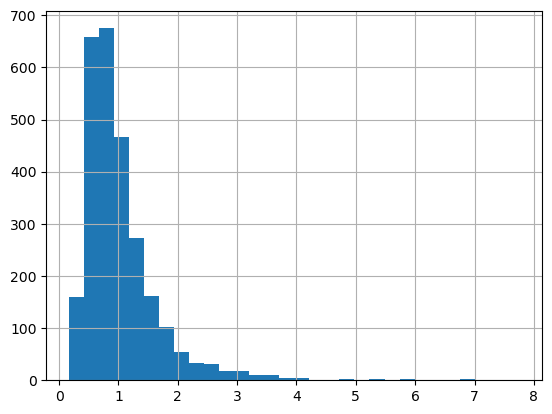

In [10]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)